In [2]:
!pip install matplotlib_venn
import wandb
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
import varname
import re
import os
from multiprocessing import Pool
import seaborn as sns
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence, Dataset

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split as tts
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

print('torch version:', torch.__version__)
print('tf version:', tf.__version__)

2022-09-20 01:39:04.376997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 01:39:04.536274: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I0920 01:39:04.639973856 3754305 ev_epoll1_linux.cc:121]     grpc epoll fd: 62
D0920 01:39:04.639992238 3754305 ev_posix.cc:141]            Using polling engine: epoll1
D0920 01:39:04.640017435 3754305 lb_policy_registry.cc:48]   registering LB policy factory for "grpclb"
D0920 01:39:04.640024644 3754305 lb_policy_registry.cc:48]   registering LB policy factory for "rls_experimental"
D0920 01:39:04.640031061 3754305 lb_policy_registry.cc:48]   registering LB policy factory for "priority_experimental"
D0920 01:39:04

torch version: 1.12.0+cu102
tf version: 2.10.0


[percpu.cc : 535] RAW: rseq syscall failed with errno 22 after membarrier sycall succeeded.


In [3]:
# using TPU through torch
import torch_xla
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.utils.serialization as xser
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

print(torch_xla.__version__)

1.12


In [4]:
# random seed fix
import random

random.seed(2022)
torch.manual_seed(2022)
np.random.seed(2022)

### Data load and Description

In [5]:
lyric = pd.read_csv('lyric_data_v3.tsv', sep = '\t')
lyric = lyric[['lyric']]

lyric_name = varname.nameof(lyric)

print(f'{lyric_name} 데이터 셋의 크기 : \n{len(lyric)}', end = '\n\n')
print(f"개별 {lyric_name}의 길이에 대한 통계치 : \n{lyric['lyric'].str.len().describe()}", end = '\n\n')
print(f"전체 {lyric_name}를 flatten한 길이 : \n{lyric['lyric'].str.len().sum()}", end = '\n\n')

lyric.head()

lyric 데이터 셋의 크기 : 
112512

개별 lyric의 길이에 대한 통계치 : 
count    112512.000000
mean        593.747254
std         280.338396
min          51.000000
25%         380.000000
50%         525.000000
75%         793.000000
max        1672.000000
Name: lyric, dtype: float64

전체 lyric를 flatten한 길이 : 
66803691



,lyric
0,Feelings nothing more than feelings Trying to ...
1,i feel alright now but don't know how to speak...
2,그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...
3,그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...
4,너를보면 나는 잠이와 이상하다 그치 잠이오면 나는 잠을자 이상하다 그치 자면서 너에...


In [ ]:
sent = pd.read_csv("data_pro", sep = ',', index_col = 0)
sent_name = varname.nameof(sent)

print(f'{sent_name} 데이터 셋의 크기 : \n{len(sent)}', end = '\n\n')
print(f"개별 {sent_name}의 길이에 대한 통계치 : \n{sent['content'].str.len().describe()}", end = '\n\n')
print(f"전체 {sent_name}를 flatten한 길이 : \n{sent['content'].str.len().sum()}", end = '\n\n')

sent.head()

sent 데이터 셋의 크기 : 
82680

개별 sent의 길이에 대한 통계치 : 
count    82680.000000
mean        29.513885
std         13.989368
min          2.000000
25%         19.000000
50%         28.000000
75%         39.000000
max        299.000000
Name: content, dtype: float64

전체 sent를 flatten한 길이 : 
2440208



,content,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,2


In [ ]:
sent['label'].value_counts()

3    23831
4    20541
1    20222
0    11087
5     4827
2     2172
Name: label, dtype: int64

In [ ]:
conv = pd.read_csv('conv.csv', sep = '\t')
conv_name = varname.nameof(conv)

print(f'{conv_name} 데이터 셋의 크기 : \n{len(conv)}', end = '\n\n')
print(f"개별 {conv_name}의 길이에 대한 통계치 : \n{conv['text'].str.len().describe()}", end = '\n\n')
print(f"전체 {conv_name}를 flatten한 길이 : \n{conv['text'].str.len().sum()}", end = '\n\n')
conv.head()

conv 데이터 셋의 크기 : 
592017

개별 conv의 길이에 대한 통계치 : 
count    592017.000000
mean         33.406010
std          32.044662
min           1.000000
25%          13.000000
50%          22.000000
75%          41.000000
max         200.000000
Name: text, dtype: float64

전체 conv를 flatten한 길이 : 
19776926



,text
0,이름만 빼고 다잠옷이다
1,중간에 신의 판결이 더 지니어 퍽퍽
2,이름 목소리가 좀 달라진건 기분탖
3,중간에 평창 말할때 평창올림픽 하는줄 영미퍼버버벅
4,씨그마가 시그널로


### Visualization

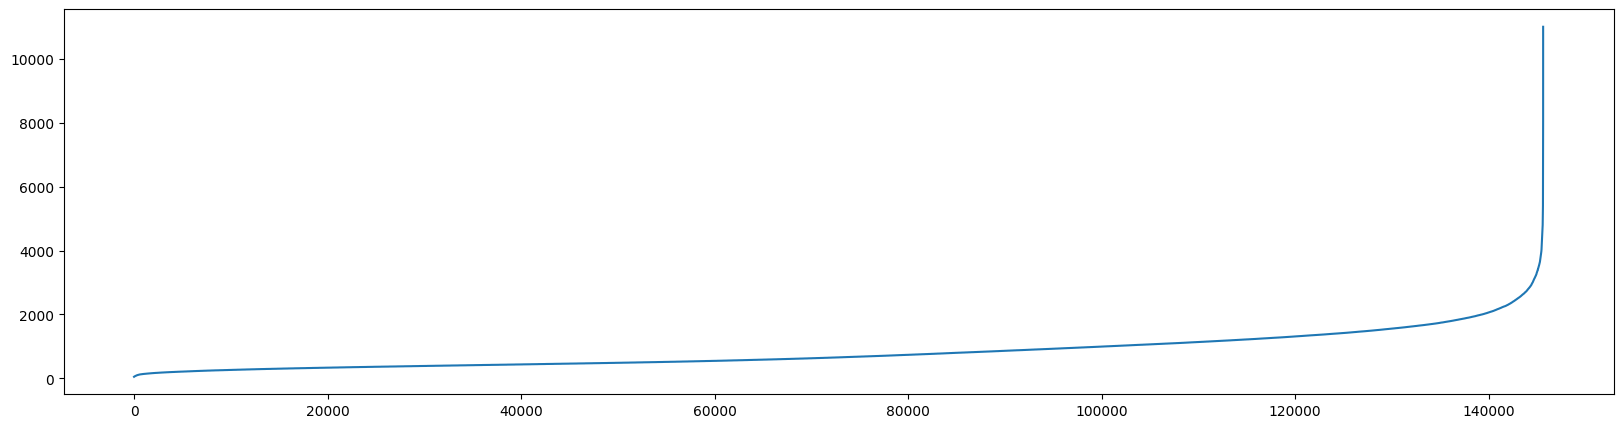

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sorted(lyric['lyric'].str.len()))
plt.show()

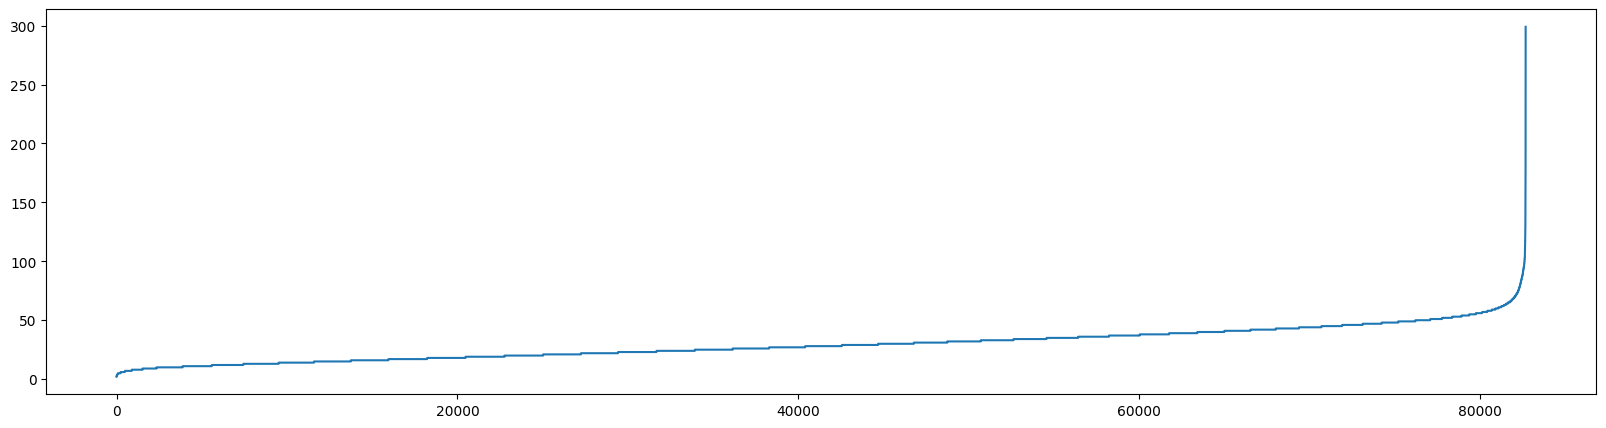

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sorted(sent['content'].str.len()))
plt.show()

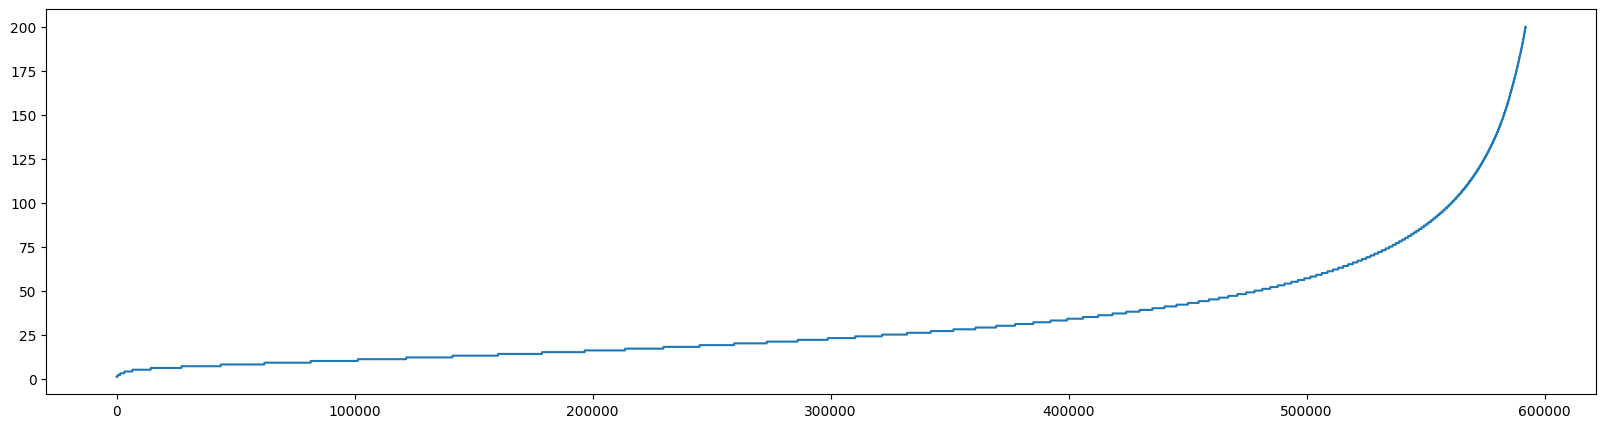

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sorted(conv['text'].str.len()))
plt.show()

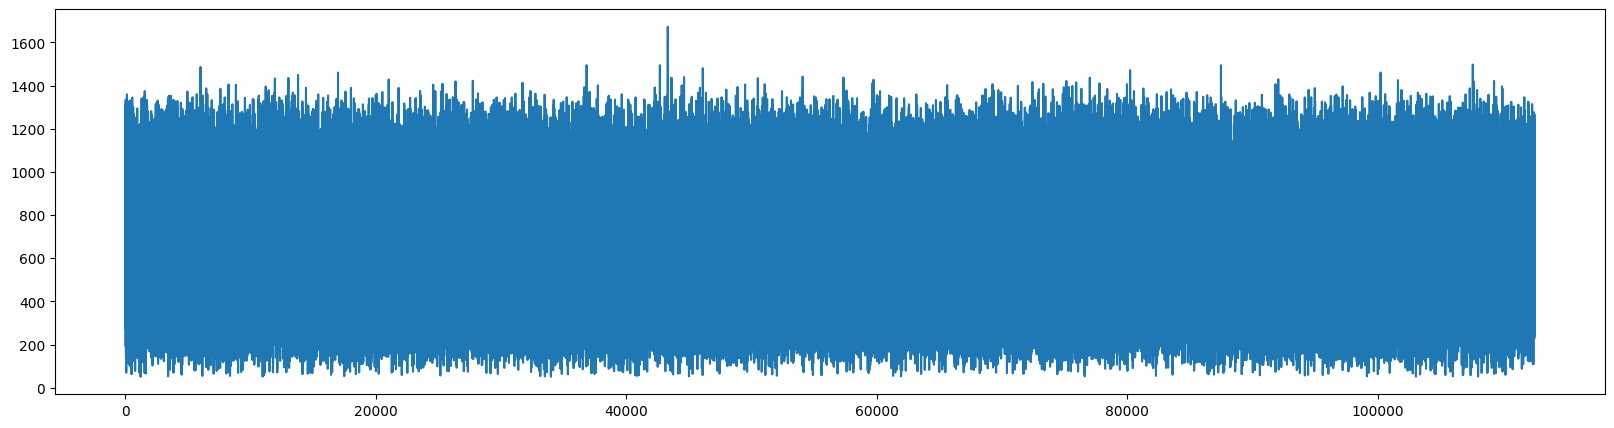

In [6]:
plt.figure(figsize=(20,5))
plt.plot(lyric['lyric'].str.len())
plt.show()

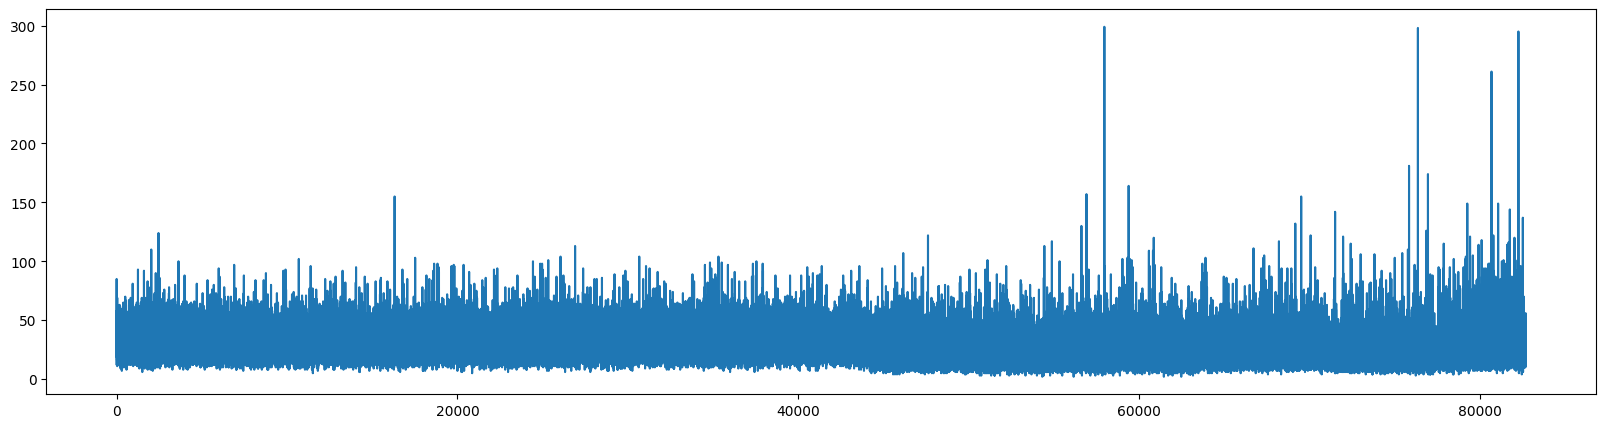

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sent['content'].str.len())
plt.show()

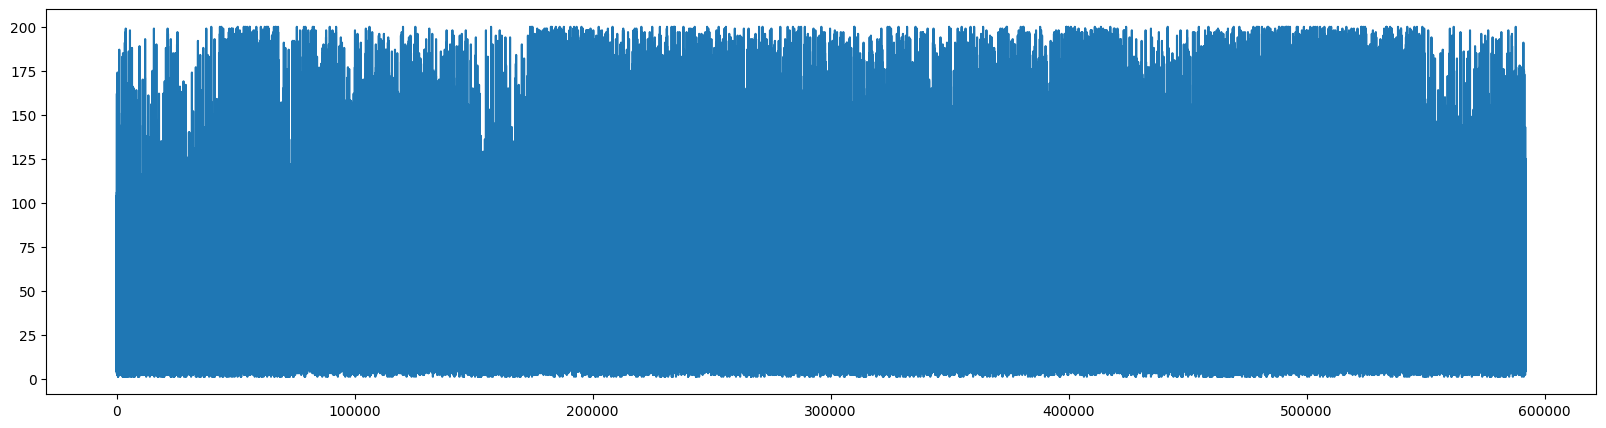

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(conv['text'].str.len())
plt.show()

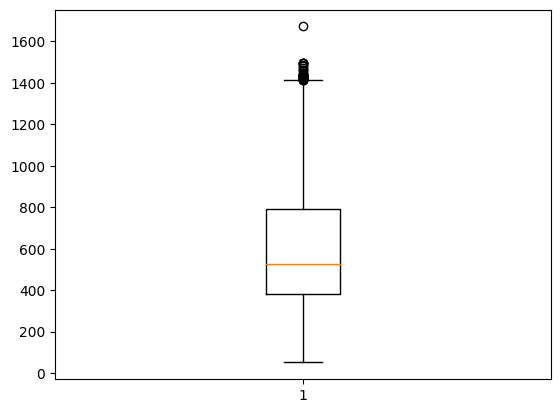

In [7]:
plt.boxplot(lyric['lyric'].str.len())
plt.show()

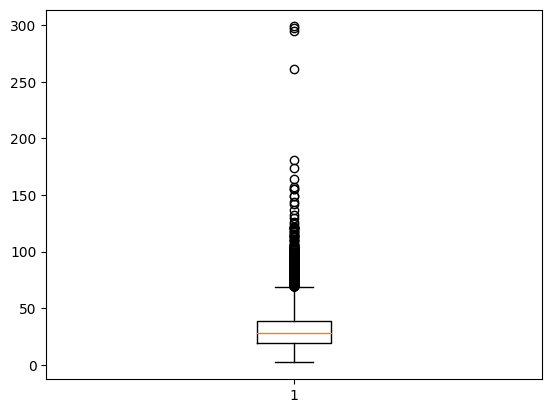

In [ ]:
plt.boxplot(sent['content'].str.len())
plt.show()

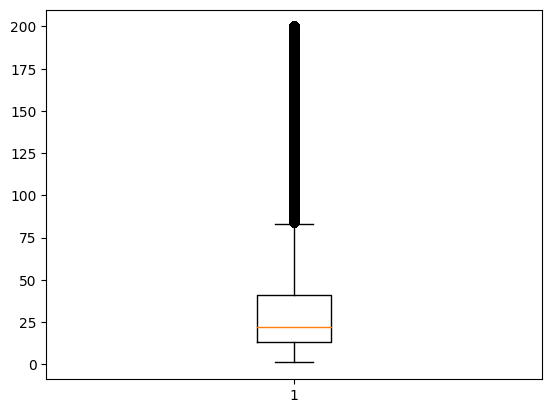

In [ ]:
plt.boxplot(conv['text'].str.len())
plt.show()

### 전체 데이터셋에 대하여 각 문장의 token길이가 512 이상인 것이 몇개 인지 조사

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

In [ ]:
print(f'감성어 데이터셋의 크기 : {len(sent)}')
print(f"감성어 데이터셋에서 token 길이가 512 이상인 문장의 수 :  {len(sent[sent['content'].apply(lambda x : len(tokenizer.encode(x)) > 512)])}")

감성어 데이터셋의 크기 : 82680
감성어 데이터셋에서 token 길이가 512 이상인 문장의 수 :  0


In [ ]:
print(f'일상어 데이터셋의 크기 : {len(conv)}')
print(f"일상어 데이터셋에서 token 길이가 512 이상인 문장의 수 :  {len(conv[conv['text'].apply(lambda x : len(tokenizer.encode(x)) > 512)])}")

일상어 데이터셋의 크기 : 592017
일상어 데이터셋에서 token 길이가 512 이상인 문장의 수 :  0


In [ ]:
print(f'가사 데이터셋의 크기 : {len(lyric)}')
print(f"가사 데이터셋에서 token 길이가 512 이상인 문장의 수 :  {len(lyric[lyric['lyric'].apply(lambda x : len(tokenizer.encode(x)) > 512)])}")

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


가사 데이터셋의 크기 : 145636
가사 데이터셋에서 token 길이가 512 이상인 문장의 수 :  33052


In [ ]:
# 가사 데이터 셋에서 Na 값 확인
lyric[lyric['lyric'].isnull()]

,lyric


### 메타데이터 불러오기

In [ ]:
df = pd.read_csv('lyric_data_v2.tsv', sep = '\t')
df.head()

,id,song_id,song_name,lyric,artist,genre,album,album_id,release
0,0,4639910,Feelings,Feelings nothing more than feelings Trying to ...,Various Artists,GN0900,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,20140512
1,8,1657318,Lovers’ Leap (Feat. Qypthone),i feel alright now but don't know how to speak...,애플스,GN0300,Sexualmetro,353020,20070625
2,9,30310140,"사랑, 그대라는 멜로디",그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...,진호,GN0100,Pastel Reflection,10047088,20170320
3,17,8068890,Girl Crush,이따 거기서 봐 이번엔 장담해 찾았어 Hot place 예감이 괜찮아 정말로 기대돼...,마마무 (Mamamoo),"GN2500,GN0200",Melting,2669407,20160226
4,19,5579388,무얼 기다리나 (Feat. 조원선),그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...,이영훈,"GN0500,GN0800",내가 부른 그림 2,2303168,20150205


### 가사데이터셋에서 mel data의 shape 안맞는 곡 제거하기

In [ ]:
index = np.load('except_list.npy')
index = df[df['id'].isin(index)].index
index

Int64Index([  3326,   3858,   5946,   6242,  18758,  19616,  22232,  22806,
             28085,  28215,  31356,  33721,  36205,  36343,  38428,  38499,
             39007,  44739,  47697,  48191,  50129,  50308,  58480,  59111,
             63757,  64811,  64952,  70819,  71181,  72325,  72935,  77405,
             78160,  78220,  78341,  81092,  84172,  86364,  88634,  90009,
             90896,  93026,  94716,  97096,  97421,  99349, 100922, 102617,
            102945, 103044, 103666, 108253, 108602, 108769, 110110, 112575,
            113475, 114541, 116077, 117623, 119406, 120614, 121317, 123907,
            124283, 127441, 131300, 131443, 135915, 136064, 137991, 140100,
            140783, 141632],
           dtype='int64')

In [ ]:
lyric = lyric.drop(index)
len(lyric)

145562

### 가사데이터셋에서 token 길이 512이하인 문장만 추출

In [ ]:
a = lyric[lyric['lyric'].apply(lambda x : len(tokenizer.encode(x)) <= 512)]
print(a)
a

                                                    lyric
0       Feelings nothing more than feelings Trying to ...
1       i feel alright now but don't know how to speak...
2       그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...
4       그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...
7       너를보면 나는 잠이와 이상하다 그치 잠이오면 나는 잠을자 이상하다 그치 자면서 너에...
...                                                   ...
145631  I'm standing on the edge And everything I know...
145632  기타로 오토바이 타자 기타로 오토바이 타자 기타로 오토바이 타자 타자 오토바이로 기...
145633  가는 세월 바람 타고 흘러가는 저 구름아 수많은 사연 담아 가는 곳이 어드메냐 구중...
145634  누구도 원했던건 아니지만 어느새 시간은 여기까지 우릴 데리고 왔지 어떻게 지내왔는지...
145635  Nobody knows where she came from The tall-and-...

[112512 rows x 1 columns]


,lyric
0,Feelings nothing more than feelings Trying to ...
1,i feel alright now but don't know how to speak...
2,그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...
4,그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...
7,너를보면 나는 잠이와 이상하다 그치 잠이오면 나는 잠을자 이상하다 그치 자면서 너에...
...,...
145631,I'm standing on the edge And everything I know...
145632,기타로 오토바이 타자 기타로 오토바이 타자 기타로 오토바이 타자 타자 오토바이로 기...
145633,가는 세월 바람 타고 흘러가는 저 구름아 수많은 사연 담아 가는 곳이 어드메냐 구중...
145634,누구도 원했던건 아니지만 어느새 시간은 여기까지 우릴 데리고 왔지 어떻게 지내왔는지...


### token길이와 mel shape로 필터링 가사데이터를 기반으로 메타데이터 선별

In [ ]:
lyric_data = pd.merge(a, df, on = 'lyric')

### 메타데이터 저장

In [ ]:
lyric_data.to_csv("lyric_data_v3.tsv", sep = '\t', index = None)

### 가사데이터는 LineByLineTextDataset 메서드로 바로 사용할 수 있게 utf-8로 인코딩해서 저장

In [ ]:
a.to_csv("lyric", sep = '\t', index = None, encoding = 'utf-8')

### token < 512인 가사의 길이 분포

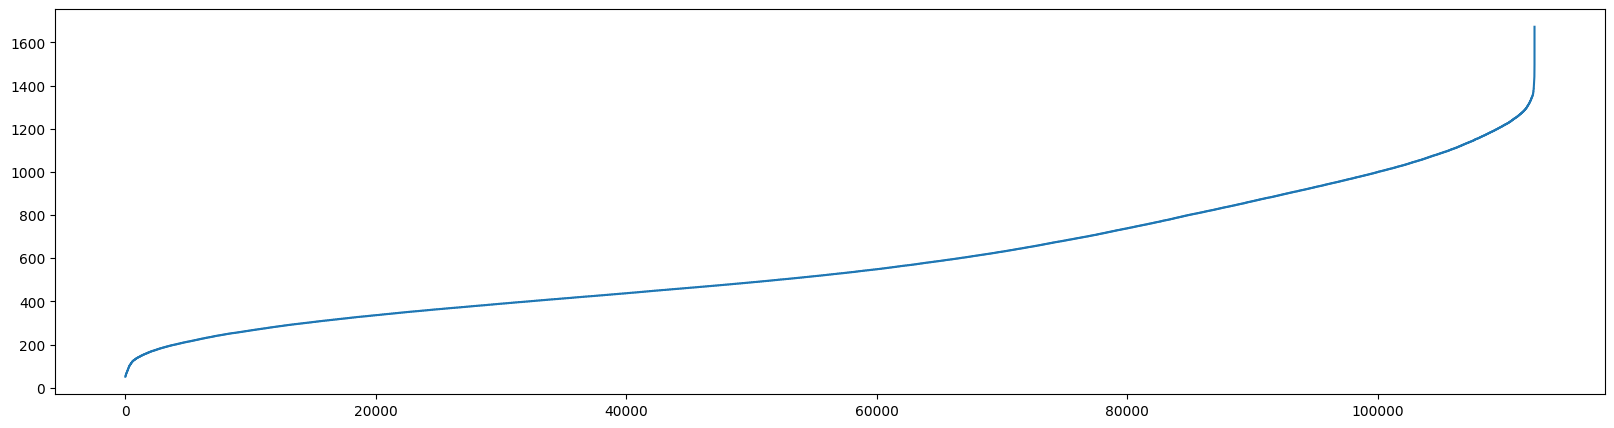

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sorted(a['lyric'].str.len()))
plt.show()

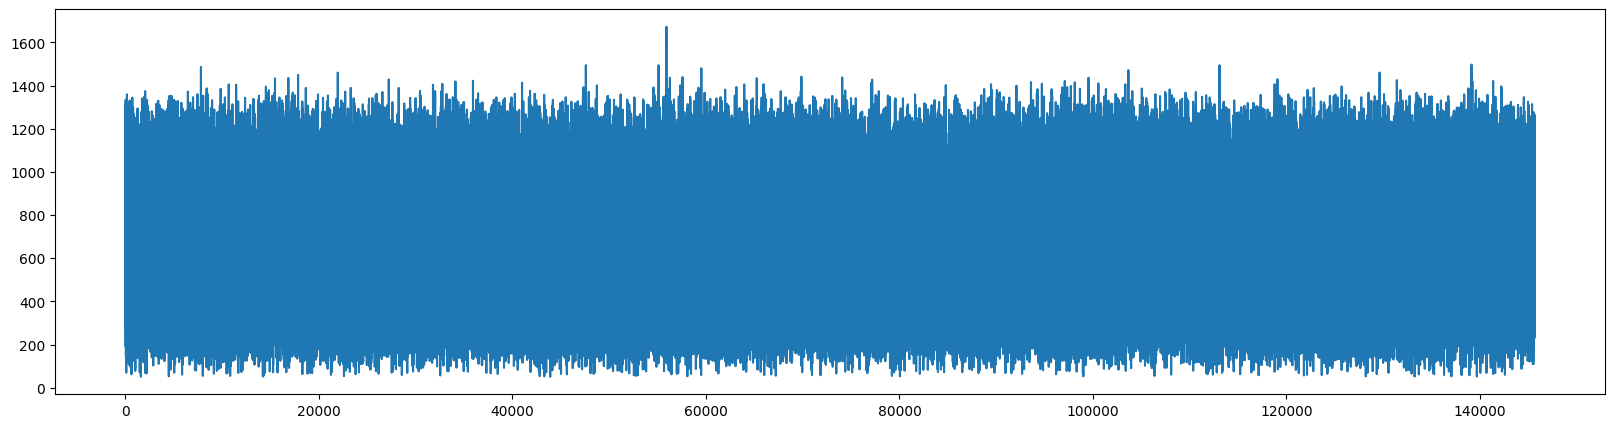

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(a['lyric'].str.len())
plt.show()

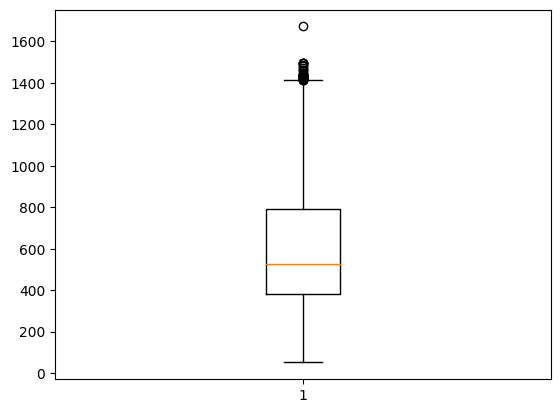

In [ ]:
plt.boxplot(a['lyric'].str.len())
plt.show()

### Overlap vocap

In [5]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

In [6]:
lyric = pd.read_csv('lyric', sep = '\t')
lyric.head()

,lyric
0,Feelings nothing more than feelings Trying to ...
1,i feel alright now but don't know how to speak...
2,그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...
3,그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...
4,너를보면 나는 잠이와 이상하다 그치 잠이오면 나는 잠을자 이상하다 그치 자면서 너에...


In [7]:
sent = pd.read_csv("data_pro", sep = ',', index_col = 0)
sent.head()

,content,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,2


In [8]:
conv = pd.read_csv('conv.csv', sep = '\t')
conv.head()

,text
0,이름만 빼고 다잠옷이다
1,중간에 신의 판결이 더 지니어 퍽퍽
2,이름 목소리가 좀 달라진건 기분탖
3,중간에 평창 말할때 평창올림픽 하는줄 영미퍼버버벅
4,씨그마가 시그널로


In [9]:
lyric_set = set()
sent_set = set()
conv_set = set()

for x in lyric['lyric']:
    lyric_set.update(tokenizer.encode(x))

for y in sent['content']:
    sent_set.update(tokenizer.encode(y))

for z in conv['text']:
    conv_set.update(tokenizer.encode(z))

### 감성어 / 가사

In [10]:
len(lyric_set.intersection(sent_set))/len(lyric_set.union(sent_set))*100

63.6036312100203

### 감성어 / 일상어

In [11]:
len(conv_set.intersection(sent_set))/len(conv_set.union(sent_set))*100

65.43383907704863

### 가사 / 일상어

In [12]:
len(lyric_set.intersection(conv_set))/len(lyric_set.union(conv_set))*100

71.93904361534419

### Venn

In [15]:
len(lyric_set.union(conv_set, sent_set))

29039

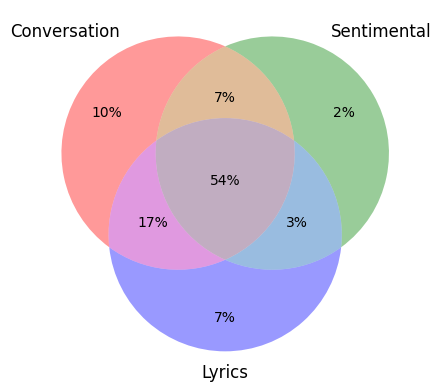

In [16]:
venn3_unweighted([set(conv_set), set(sent_set), set(lyric_set)], ('Conversation','Sentimental','Lyrics'),
                subset_label_formatter=lambda x : f"{(x/len(lyric_set.union(conv_set, sent_set))):1.0%}")
plt.show()

In [17]:
a = np.array([100, 71.9,  63.6, 71.9, 100, 65.4, 63.6, 65.4, 100], dtype=np.float32)
a = a.reshape(3,3)

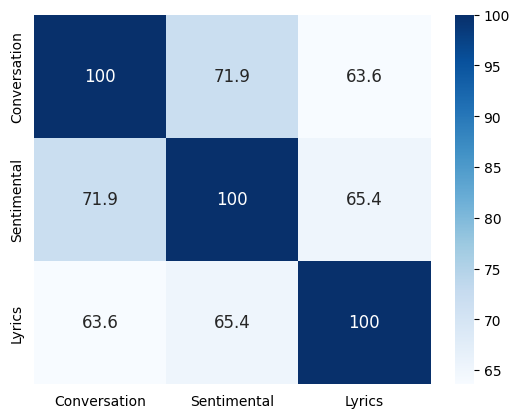

In [33]:
LABELS = ['Conversation','Sentimental','Lyrics']
h = sns.heatmap(a, annot= True,xticklabels=LABELS, yticklabels=LABELS, cmap='Blues', fmt='g',annot_kws={"size": 12})

h.tick_params(left=False, bottom=False)
#plt.yticks(rotation=0)
plt.show()